##### Select only the data from february

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = r'MetroPT3(AirCompressor).csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Convert the first column to datetime
data.iloc[:, 1] = pd.to_datetime(data.iloc[:, 1], format='%Y-%m-%d %H:%M:%S')

df = data[:214850]
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d/%m/%Y %H:%M:%S")

df.head(5)

C:\Users\JoãoMarquesDias\AppData\Local\Temp\ipykernel_8028\797563287.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d/%m/%Y %H:%M:%S")


,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


#### Determine the minima and maxima

In [2]:
# Determining the maxima and minima
n = 15  # Number of neighbors to consider on each side

# Extract the second column (TP3)
tp3 = df.iloc[:, 3].values  # Second column as a NumPy array

# Initialize lists to store indices of maxima and minima
maxima_indices = []
minima_indices = []

# Iterate through the data points
for i in range(n, len(tp3) - n):
    # Get the neighborhood
    neighborhood = tp3[i - n:i + n + 1]
    
    # Check for maximum
    if tp3[i] == max(neighborhood):
        # Ensure the current index is the most recent occurrence of the maximum
        if i == np.max(np.where(neighborhood == tp3[i])[0]) + i - n:
            maxima_indices.append(i)
    
    # Check for minimum
    if tp3[i] == min(neighborhood):
        # Ensure the current index is the most recent occurrence of the minimum
        if i == np.max(np.where(neighborhood == tp3[i])[0]) + i - n:
            minima_indices.append(i)

# Output results
print(f"Maxima indices: {maxima_indices}")
print(f"Minima indices: {minima_indices}")
print(len(maxima_indices))
print(len(minima_indices))

'''
export_data = pd.DataFrame({
    'Minima Indices': pd.Series(minima_indices),
    'Maxima Indices': pd.Series(maxima_indices)
})

# Export the DataFrame to a CSV file
export_data.to_csv('maxima_minima_indices.csv', index=False)
'''


Maxima indices: [151, 357, 559, 763, 966, 1166, 1369, 1548, 1726, 1908, 2056, 2252, 2386, 2496, 2687, 2869, 3017, 3225, 3345, 3534, 3746, 3904, 4152, 4382, 4604, 4791, 5005, 5199, 5395, 5527, 5632, 5847, 5927, 6067, 6243, 6403, 6539, 6762, 6908, 7047, 7114, 7147, 7358, 7426, 7635, 7814, 7997, 8157, 8289, 8452, 8585, 8811, 8937, 9100, 9277, 9488, 9583, 9781, 9950, 10104, 10287, 10448, 10666, 10807, 10988, 11100, 11320, 11455, 11622, 11798, 11975, 12135, 12306, 12474, 12681, 12900, 13083, 13257, 13438, 13610, 13784, 13956, 14129, 14302, 14474, 14646, 14820, 14994, 15170, 15340, 15513, 15686, 15860, 16035, 16208, 16383, 16559, 16735, 16922, 17122, 17324, 17527, 17732, 17937, 18106, 18311, 18515, 18722, 18925, 19130, 19334, 19537, 19745, 19949, 20169, 20356, 20633, 20885, 21127, 21367, 21600, 21852, 22103, 22349, 22590, 22843, 23070, 23326, 23577, 23831, 24083, 24339, 24581, 24817, 25079, 25171, 25307, 25523, 25653, 25857, 26015, 26245, 26437, 26612, 26865, 26999, 27267, 27439, 27654, 2780

"\nexport_data = pd.DataFrame({\n    'Minima Indices': pd.Series(minima_indices),\n    'Maxima Indices': pd.Series(maxima_indices)\n})\n\n# Export the DataFrame to a CSV file\nexport_data.to_csv('maxima_minima_indices.csv', index=False)\n"

#### Determine repeated entries (more than one maximum/minimum in a row)

In [3]:
def merge_with_origin(list1, list2):
    # Merge the lists with origin flags
    merged = sorted([(val, 0) for val in list1] + [(val, 1) for val in list2])
    
    # Create the table
    table = {
        "Merged_entries": [entry[0] for entry in merged],
        "Blue?": [entry[1] for entry in merged],
    }
    
    return table

table = merge_with_origin(maxima_indices, minima_indices)

peaks = pd.DataFrame(table)


#Check repeated blue/red lines
repeated_entries = []
for i in range(1, len(peaks)):
    if peaks.loc[i, "Blue?"] == peaks.loc[i - 1, "Blue?"]:
        repeated_entries.append(peaks.loc[i-1, "Merged_entries"])

# Print the repeated entries
print("Repeated entries in sequence:", repeated_entries)

Repeated entries in sequence: [np.int64(45294), np.int64(63704), np.int64(91043), np.int64(93923), np.int64(190534)]


#### Determining the entries for which there are consecutive minima/maxima

In [4]:
for i in range(0,len(minima_indices)):
    if minima_indices[i] in (45294, 63704, 91043, 93923): #The values for the repeated cells, given above
        print(f"minima_indices[{i}] = ", minima_indices[i])

for i in range(0,len(maxima_indices)):
    if maxima_indices[i] == 190564:
        print(f"maxima_indices[{i}] = ", maxima_indices[i])

minima_indices[255] =  45294
minima_indices[369] =  63704
minima_indices[525] =  91043
minima_indices[543] =  93923
maxima_indices[1038] =  190564


| Coordinate| Peak type | Index  |
| --------  | -------   | ------ |
| 45294     | Minimum   | 255    |
| 63704     | Minimum   | 369    |
| 91043     | Minimum   | 525    |
| 93923     | Minimum   | 543    |
| 190564    | Maximum   | 1038   |

#### Creating new maxima and minima lists without the spurious results (and adding one maximum that escaped our algorithm)

In [5]:
maxima_indices_fixed = np.delete(maxima_indices, [1038])
minima_indices_fixed = np.delete(minima_indices, [255,369,525,543,1038])

minima_indices_fixed = np.append(minima_indices_fixed, 190074) ##adding a maximum that was missing
minima_indices_fixed = np.sort(minima_indices_fixed)

print(len(maxima_indices_fixed))
print(len(minima_indices_fixed))

1179
1179


#### Plotting TP3 against the indices

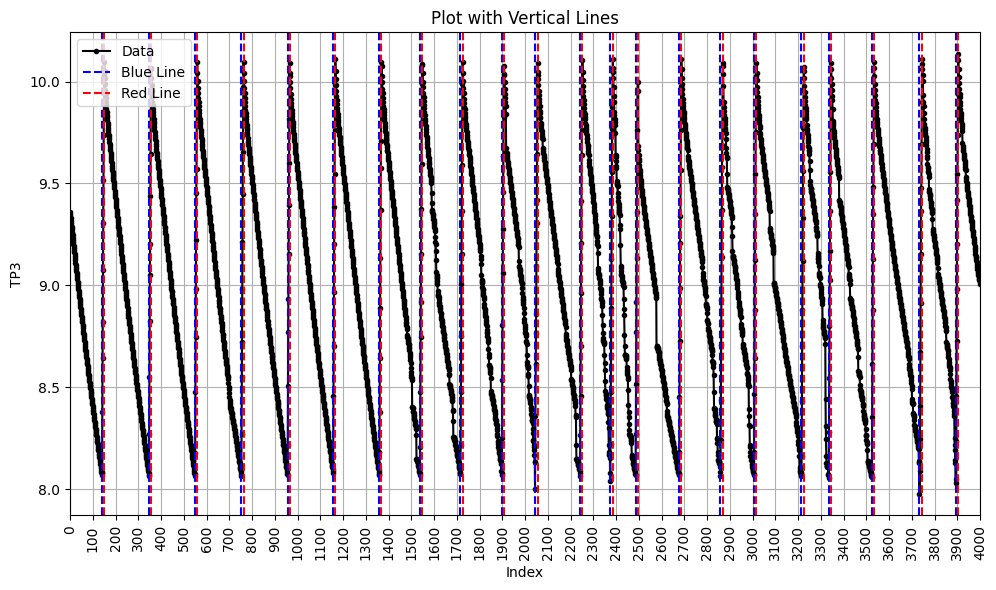

In [6]:
plt.figure(figsize=(10, 6))
# Extract the first and third columns
#x = data.iloc[:400, 0]  # First column (datetime)
aux = int(4000*0)
data_interval = range(aux, aux+4000)
x = data_interval
y = df.iloc[data_interval, 3]  # Third column
plt.plot(x, y, marker='.', linestyle='-', color='black', label='Data')


# Plot blue vertical lines
for idx in minima_indices_fixed[:]:
    plt.axvline(x=idx, color='blue', linestyle='--', label='Blue Line' if idx == minima_indices[0] else "")

# Plot red vertical lines
for idx in maxima_indices_fixed[:]:
    plt.axvline(x=idx, color='red', linestyle='--', label='Red Line' if idx == maxima_indices[0] else "")

# Add labels, title, and grid
plt.xlabel('Index')
plt.ylabel('TP3')
plt.title('Plot with Vertical Lines')
plt.grid(True)
tick_spacing = 100  # Adjust this for denser or sparser ticks
ticks = range(aux, aux + 4000 + 1, tick_spacing)
plt.xticks(ticks, rotation=90) # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.xlim(aux, aux+4000)


# Add a legend
plt.legend()

# Show the plot
plt.show()

In [7]:
'''export_data = pd.DataFrame({
    'Minima Indices': pd.Series(minima_indices_fixed),
    'Maxima Indices': pd.Series(maxima_indices_fixed)
})

# Export the DataFrame to a CSV file
export_data.to_csv('maxima_minima_indices_fixed.csv', index=False)'''

"export_data = pd.DataFrame({\n    'Minima Indices': pd.Series(minima_indices_fixed),\n    'Maxima Indices': pd.Series(maxima_indices_fixed)\n})\n\n# Export the DataFrame to a CSV file\nexport_data.to_csv('maxima_minima_indices_fixed.csv', index=False)"

#### Converting the timestamp insto seconds since first measurement (01/02/2020  00:00:00)

In [8]:
# Calculate seconds since the first entry
df["timestamp"] = (df["timestamp"] - df["timestamp"].iloc[0]).dt.total_seconds()

C:\Users\JoãoMarquesDias\AppData\Local\Temp\ipykernel_8028\820295178.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["timestamp"] = (df["timestamp"] - df["timestamp"].iloc[0]).dt.total_seconds()


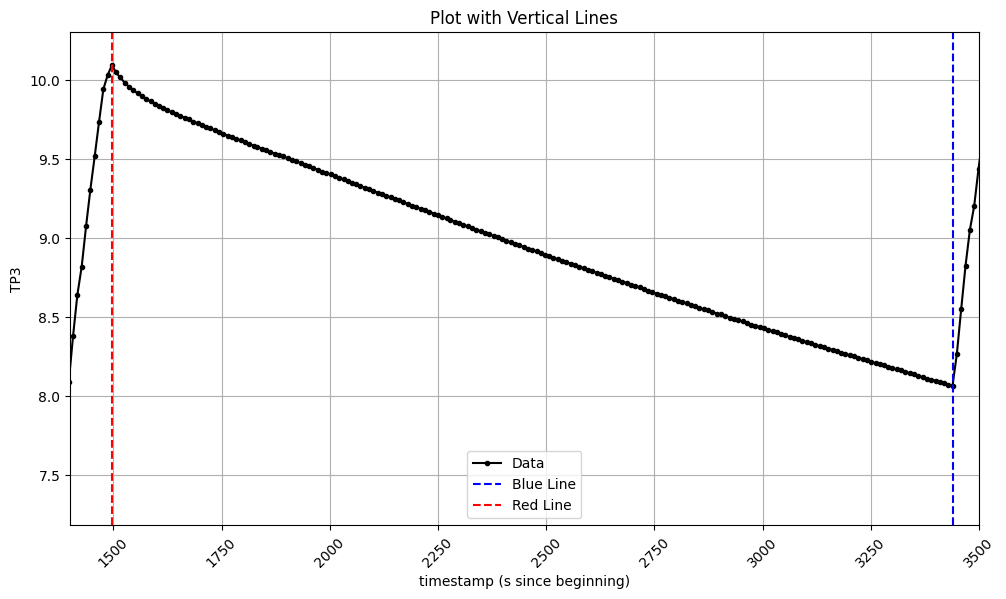

In [9]:
x = df.iloc[:, 1] #Timestamp
y = df.iloc[:, 3] #TP3
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='.', linestyle='-', color='black', label='Data')

# Plot blue vertical lines
for idx in minima_indices[:]:
    plt.axvline(x=df.iloc[idx, 1], color='blue', linestyle='--', label='Blue Line' if idx == minima_indices_fixed[0] else "")

# Plot red vertical lines
for idx in maxima_indices[:]:
    plt.axvline(x=df.iloc[idx,1], color='red', linestyle='--', label='Red Line' if idx == maxima_indices_fixed[0] else "")

# Add labels, title, and grid
plt.xlabel('timestamp (s since beginning)')
plt.ylabel('TP3')
plt.title('Plot with Vertical Lines')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Add a legend
plt.legend()
aux=200000
plt.xlim(1400, 3500)

# Show the plot
plt.show()

#### Calculating $T_{run}$ and $T_{idle}$ vectors

In [10]:
Trun = []
Tidle = []

for i in range(len(minima_indices_fixed)):
   try:
    trun_seconds = df['timestamp'].iloc[maxima_indices_fixed[i]] - df['timestamp'].iloc[minima_indices_fixed[i]]
    Trun.append(int(trun_seconds))

    tidle_seconds = df['timestamp'].iloc[minima_indices_fixed[i + 1]] - df['timestamp'].iloc[maxima_indices_fixed[i]]
    Tidle.append(int(tidle_seconds))
   except:
    Tidle.append(0)
print(Trun)
print(Tidle)

[109, 99, 99, 99, 100, 100, 99, 99, 99, 100, 119, 100, 109, 99, 99, 99, 109, 100, 99, 89, 119, 109, 99, 109, 109, 99, 109, 109, 109, 109, 109, 109, 109, 110, 109, 109, 110, 109, 109, 109, 12929, 30, 139, 109, 89, 99, 109, 109, 99, 109, 109, 109, 119, 109, 119, 99, 129, 99, 99, 109, 129, 99, 109, 109, 109, 109, 119, 119, 109, 99, 100, 119, 99, 149, 100, 99, 109, 99, 99, 99, 109, 109, 109, 109, 99, 109, 109, 109, 99, 109, 99, 99, 99, 100, 109, 109, 109, 109, 99, 99, 99, 100, 100, 99, 109, 99, 99, 99, 99, 109, 109, 99, 99, 109, 100, 99, 109, 99, 99, 100, 99, 99, 109, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 109, 99, 109, 100, 109, 139, 99, 119, 119, 100, 119, 99, 99, 109, 99, 109, 99, 109, 119, 109, 99, 109, 99, 109, 149, 109, 139, 109, 119, 109, 109, 109, 138, 99, 119, 119, 109, 109, 109, 119, 109, 649, 12065, 99, 99, 99, 109, 109, 119, 109, 109, 109, 109, 109, 129, 99, 89, 109, 109, 109, 109, 118, 109, 109, 119, 119, 99, 119, 109, 109, 119, 99, 109, 119, 109, 109, 109, 109, 109, 99, 100,

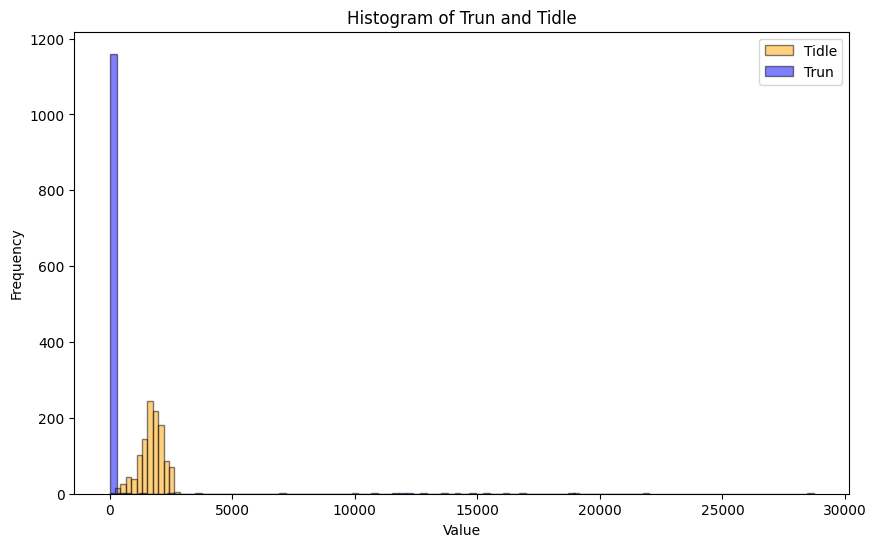

In [11]:
plt.figure(figsize=(10, 6))

plt.hist(Tidle, bins=100, alpha=0.5, label='Tidle', color='orange', edgecolor='black')
plt.hist(Trun, bins=100, alpha=0.5, label='Trun', color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Trun and Tidle')
plt.legend()

# Show the plot
plt.show()

Não é muito eficiente simplesmente retirar os pontos de $T_{run}$ e $T_{idle}$ que tiverem valores altos. É preciso ter os T's originais para reconstruir a time series e saber quando um ciclo começa e outro acaba (p. ex. como se saberia onde começar e acabar de contar os valores dos sensores digitais?). Primeiro construir $\bold{X}$ e depois apagar $X_m$ individuais para os quais $T_{run}$ ou $T_{idle}$ (ou outros parâmetros) tenha valores absurdos.

#### Creating coordinates for box centers

In [12]:
Box_centers = np.zeros((len(Trun), 7))

# Populate the matrix
for i in range(len(Trun)):
    Trun_aux = Trun[i]
    Tidle_aux = Tidle[i]
    
    # First two components: Trun_1 * (1/4, 3/4)
    Box_centers[i, 0] = df['timestamp'].iloc[minima_indices_fixed[i]] + Trun_aux * (1 / 4)
    Box_centers[i, 1] = df['timestamp'].iloc[minima_indices_fixed[i]] + Trun_aux * (3 / 4)
    
    # Remaining five components: Tidle_1 * (1/10, 3/10, 5/10, 7/10, 9/10)
    fractions = [1/10, 3/10, 5/10, 7/10, 9/10]
    for j, fraction in enumerate(fractions, start=2):
        Box_centers[i, j] = df['timestamp'].iloc[maxima_indices_fixed[i]] + Tidle_aux * fraction

#### Plotting graph with box centres

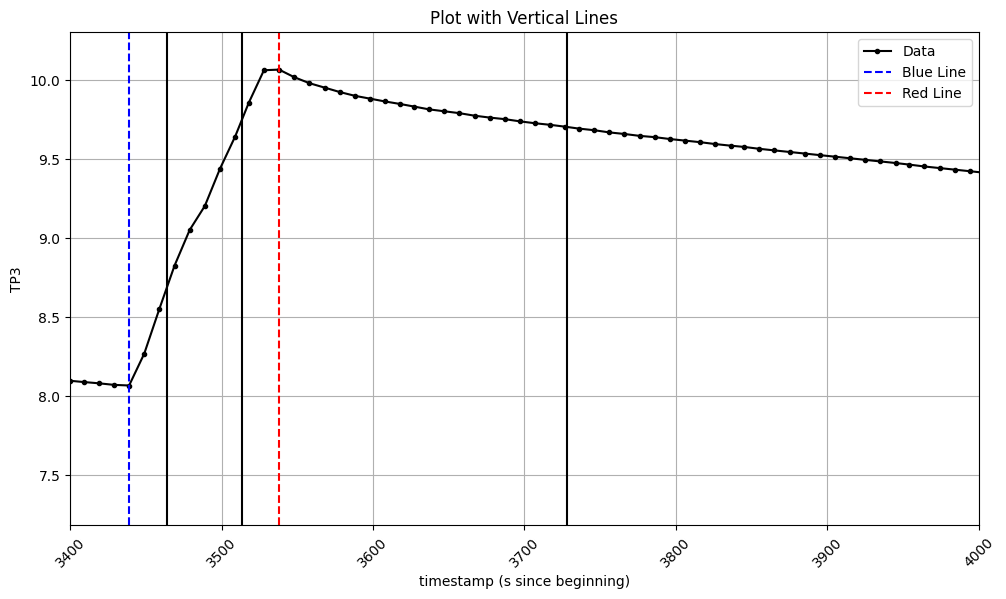

In [13]:
x = df.iloc[:, 1] #Timestamp
y = df.iloc[:, 3] #TP3
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='.', linestyle='-', color='black', label='Data')

# Plot blue vertical lines
for idx in minima_indices[:]:
    plt.axvline(x=df.iloc[idx, 1], color='blue', linestyle='--', label='Blue Line' if idx == minima_indices_fixed[0] else "")

# Plot red vertical lines
for idx in maxima_indices[:]:
    plt.axvline(x=df.iloc[idx,1], color='red', linestyle='--', label='Red Line' if idx == maxima_indices_fixed[0] else "")

# Plot red vertical lines
for idx in Box_centers[1, :]:
    plt.axvline(x=idx, color='black', linestyle='-', label='')

# Add labels, title, and grid
plt.xlabel('timestamp (s since beginning)')
plt.ylabel('TP3')
plt.title('Plot with Vertical Lines')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Add a legend
plt.legend()
aux=200000
plt.xlim(3400, 4000)

# Show the plot
plt.show()

#### Determining $B_n(TP3)$

In [14]:
Boxes_tp3_flattened = []
Boxes_tp3_flattened.append(float(df['TP3'][143])) #See first value by eye
Box_centers_flattened = Box_centers.flatten().tolist()

for i in range(1, len(Box_centers_flattened)-1):
    flag_min=1e5
    aux = 0
    for j in df[(df['timestamp']>=Box_centers_flattened[i-1]) & (df['timestamp']<=Box_centers_flattened[i+1])]['timestamp'].to_list():
        if abs(Box_centers_flattened[i] - j) < flag_min:
            flag_min = abs(Box_centers_flattened[i] - j)
            aux = j
    Boxes_tp3_flattened.append(float(df[df['timestamp'] == aux]['TP3']))

Boxes_tp3_flattened.append(float(df['TP3'][214651])) #See last one by eye

#Unflatten the list
Boxes_tp3 = np.reshape(Boxes_tp3_flattened, (len(Trun), 7))



C:\Users\JoãoMarquesDias\AppData\Local\Temp\ipykernel_8028\3472579514.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Boxes_tp3_flattened.append(float(df[df['timestamp'] == aux]['TP3']))


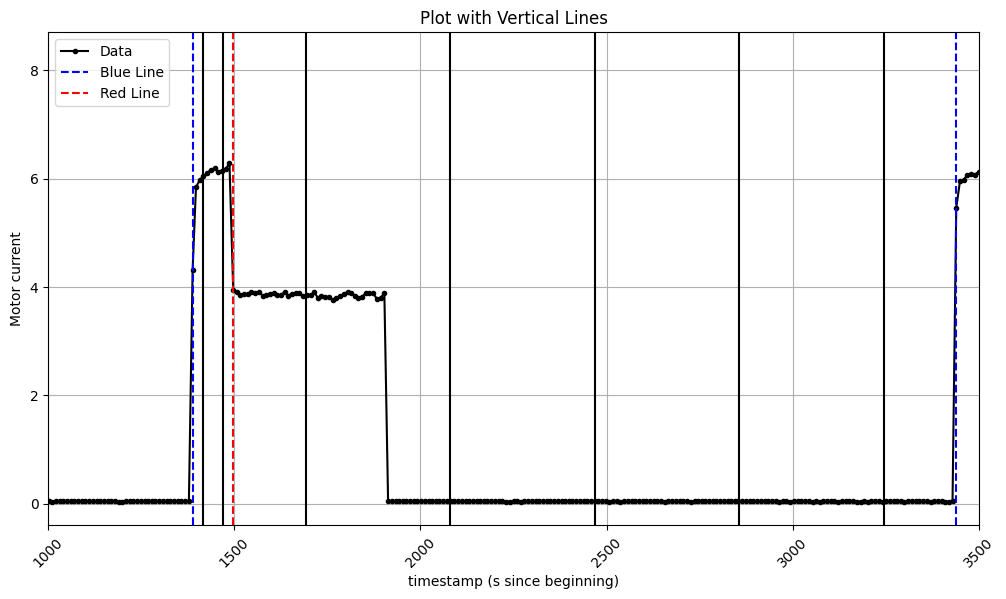

In [15]:
x = df.iloc[:, 1] #Timestamp
y = df.iloc[:, 8] #TP3
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='.', linestyle='-', color='black', label='Data')

# Plot blue vertical lines
for idx in minima_indices[:]:
    plt.axvline(x=df.iloc[idx, 1], color='blue', linestyle='--', label='Blue Line' if idx == minima_indices_fixed[0] else "")

# Plot red vertical lines
for idx in maxima_indices[:]:
    plt.axvline(x=df.iloc[idx,1], color='red', linestyle='--', label='Red Line' if idx == maxima_indices_fixed[0] else "")

# Plot red vertical lines
for idx in Box_centers[0, :]:
    plt.axvline(x=idx, color='black', linestyle='-', label='')

# Add labels, title, and grid
plt.xlabel('timestamp (s since beginning)')
plt.ylabel('Motor current')
plt.title('Plot with Vertical Lines')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Add a legend
plt.legend()
aux=200000
plt.xlim(1000, 3500)

# Show the plot
plt.show()

#### Determining $B_n(Mc)$

In [16]:
Boxes_mc_flattened = []
Boxes_mc_flattened.append(float(df['Motor_current'][143])) #See first value by eye

for i in range(1, len(Box_centers_flattened)-1):
    flag_min=1e5
    aux = 0
    for j in df[(df['timestamp']>=Box_centers_flattened[i-1]) & (df['timestamp']<=Box_centers_flattened[i+1])]['timestamp'].to_list():
        if abs(Box_centers_flattened[i] - j) < flag_min:
            flag_min = abs(Box_centers_flattened[i] - j)
            aux = j
    Boxes_mc_flattened.append(float(df[df['timestamp'] == aux]['Motor_current']))

Boxes_mc_flattened.append(float(df['Motor_current'][214651])) #See last one by eye

Boxes_mc = np.reshape(Boxes_mc_flattened, (len(Trun), 7))



C:\Users\JoãoMarquesDias\AppData\Local\Temp\ipykernel_8028\2706994322.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Boxes_mc_flattened.append(float(df[df['timestamp'] == aux]['Motor_current']))


$$\bold{X}_{Analog} = \left(B_1(TP3), B_2(TP3), ..., B_7(TP3);\quad B_1(Mc), ..., B_7(Mc);\quad T_{run}, T_{idle}\right)$$

$$\bold{X}_{Digi} =  \left(\sum_{T_{cycle}}D_1, \sum_{T_{cycle}}D_2, ..., \sum_{T_{cycle}}D_7;\quad T_{run}, T_{idle}\right)$$

#### Building $\bold{X}_{Analog}^{Fev}$

In [17]:
print(Boxes_tp3.shape, Boxes_mc.shape, len(Trun), len(Tidle))

Trun_array = np.array(Trun).reshape(-1, 1)  # Reshape to a column
Tidle_array = np.array(Tidle).reshape(-1, 1)  # Reshape to a column

# Horizontally stack the arrays
X_analog = pd.DataFrame(np.hstack((Boxes_tp3, Boxes_mc, Trun_array, Tidle_array)), columns=['TP3_1', 'TP3_2', 'TP3_3', 'TP3_4', 'TP3_5' ,'TP3_6', 'TP3_7', 'MC_1', 'MC_2', 'MC_3', 'MC_4', 'MC_5', 'MC_6', 'MC_7', 'Trun', 'Tidle'])

(1179, 7) (1179, 7) 1179 1179


#### Remove anomalous values from the dataset (20 due to $T_{run}$, and 5 due to $T_{idle}$):

In [18]:
X_analog.sort_values(by='Tidle', ascending=False).head(5)

,TP3_1,TP3_2,TP3_3,TP3_4,TP3_5,TP3_6,TP3_7,MC_1,MC_2,MC_3,MC_4,MC_5,MC_6,MC_7,Trun,Tidle
223,8.742,9.756,8.328,9.358,9.358,9.358,7.436,6.1275,6.2325,0.0375,0.04,0.04,0.0400,5.6925,109.0,21998.0
40,9.310,9.990,9.650,9.358,9.358,9.358,9.630,0.0375,3.9700,0.0300,0.04,0.04,0.0400,6.2750,12929.0,19134.0
558,9.208,10.090,9.700,9.358,9.358,9.358,9.070,0.0325,3.9750,0.0325,0.04,0.04,0.0400,3.7025,14775.0,16173.0
391,8.444,9.528,9.624,9.358,9.358,9.696,9.494,5.8300,6.1375,0.0325,0.04,0.04,3.7875,3.7625,99.0,14135.0
1037,8.856,9.818,9.532,9.358,9.358,9.708,8.816,0.0400,4.0025,0.0425,0.04,0.04,3.8200,0.0375,6993.0,9951.0


In [19]:
remove_list = X_analog.sort_values(by='Trun', ascending=False).index[:20].tolist()
remove_list.extend(X_analog.sort_values(by='Tidle', ascending=False).index[:5].tolist())
remove_list = list(set(remove_list))  # Remove duplicates
remove_list.sort()

X_analog = X_analog.drop(index=remove_list)

In [20]:
remove_list

[40,
 174,
 175,
 223,
 246,
 247,
 276,
 348,
 349,
 391,
 430,
 473,
 558,
 680,
 681,
 791,
 792,
 922,
 923,
 963,
 1037,
 1124]

#### Normalize the data

In [34]:
scaler = StandardScaler()

# Fit the scaler to the data and transform it
X_analog_feb = scaler.fit_transform(X_analog)
pd.DataFrame(X_analog_feb).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.335272,0.498441,0.291704,0.237725,-0.024209,-0.271463,-0.358901,1.473840,0.209347,0.706491,-0.511242,-0.250321,-0.157878,-0.127435,0.069999,0.490842
1,-0.395713,-0.526163,0.144790,0.155690,-0.071322,-0.279900,-0.420888,0.771283,0.597403,0.755347,-0.511242,-0.250321,-0.162117,-0.122121,-0.856644,0.409351
2,-1.029233,1.077566,0.211569,0.188504,-0.079175,-0.347403,-0.470478,1.549114,0.300655,0.095791,-0.511242,-0.250321,-0.157878,-0.122121,-0.856644,0.451141
3,0.968792,1.857156,0.171502,0.155690,-0.047765,-0.279900,-0.396093,1.574206,-0.361322,2.465308,-0.511242,-0.253145,-0.157878,-0.122121,-0.856644,0.428157
4,-0.769328,-0.993918,0.211569,0.229522,-0.016356,-0.237711,-0.296915,0.696008,1.305033,2.172172,-0.511242,-0.253145,-0.157878,-0.122121,-0.763980,0.367561


In [35]:
np.save("npy_files/X_analog_feb.npy", X_analog_feb)